In [2]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import cartopy
import cartopy.crs as ccrs
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, u_darrays as uda, u_met
import glob
import metpy
from metpy import calc
from metpy.units import units
from scipy import stats
import metpy
from metpy import calc
from metpy.units import units
import pickle as pkl
import matplotlib.patches as patches
pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
regions = {
'equatorial' : [(-5,0)],
'transition' : [(-8,-5)],
'central' : [(-12,-8)],
'southern' : [(-18,-15)]}
h = 2000

In [4]:
topo_full = xr.open_dataset('/media/ck/Elements/SouthAmerica/ERA5/hourly/ERA5_static_hourly_0.25deg_peru.nc')
topo_full = uda.flip_lat(topo_full)

In [5]:
height = xr.open_dataset('/media/ck/Elements/SouthAmerica/ERA5/hourly/topo_ERA5_peru.nc')['h']


In [6]:
def read(region):
    
    alls = regions[region]
    hei = height.sel(latitude=slice(alls[0][0], alls[0][1])).mean('latitude').squeeze()
    topo = topo_full['z'].sel(latitude=slice(alls[0][0], alls[0][1])).mean('latitude').squeeze()
    inpath = '/media/ck/Elements/SouthAmerica/ERA5/hourly/'+region+'_cross_15UTC_1985-2018_peru_v2.nc'
    
    ds = xr.open_dataset(inpath)
    ds_filtered = ds.where(ds['z']>topo)
    
    return ds_filtered

In [7]:
def calc_from_era(ds):
    pdub = np.array([list(ds.level.values),]*len(ds.longitude)).T
    p = units.Quantity(pdub, 'hPa')
    #print(p)
    t = units.Quantity(ds['t'].values, 'K')
    q = units.Quantity(ds['q'].values, 'kg/kg')
    dew = calc.dewpoint_from_specific_humidity(q, t, p)
    #ipdb.set_trace()
    theta_es = np.array(calc.saturation_equivalent_potential_temperature(p,t))#-273.15
    theta_e = np.array(calc.equivalent_potential_temperature(p,t,dew))#-273.15
    theta = np.array(calc.potential_temperature(p,t))
    theta_e_mine = u_met.theta_e(ds.level.values, ds['t'].values-273.15, ds['q'].values)+273.15
    
    tes = ds['q'].copy(deep=True)
    te = ds['q'].copy(deep=True)
    tem = ds['q'].copy(deep=True)
    th = ds['q'].copy(deep=True)
    
    tes.values = theta_es
    te.values = theta_e
    tem.values = theta_e_mine
    th.values = theta
    ds['theta_es'] = tes
    ds['theta_e'] = te
    ds['theta_em'] = tem
    ds['theta'] = th

    return ds#theta_es, theta_e, theta_e_mine

In [8]:
def apply_drywet(ds, region, spell=3, minus='0days', plus='0days', area=0.2):
    dwspells = pkl.load(open("/home/ck/DIR/cornkle/data/HUARAZ/saves/"+region+"_dw_spellDates_"+str(area)+"perc_v2.p", "rb"))
    #dwspells = pkl.load(open("/home/ck/DIR/cornkle/data/HUARAZ/saves/"+region+"_dw_spellDates_"+str(area)+"perc_3-4_5-6_7-8_StartOfSpell.p", "rb"))
    #dwspells = pkl.load(open("/home/ck/DIR/cornkle/data/HUARAZ/saves/"+region+"_dw_spellDates_"+str(area)+"perc_v2_perPix_split.p", "rb"))  #for crosssection
    dds = dwspells['dry'+str(spell)] -pd.Timedelta(minus) + pd.Timedelta(plus)
    wds = dwspells['wet'+str(spell)] -pd.Timedelta(minus) + pd.Timedelta(plus)
    
    print('dry', len(dds), 'wet', len(wds))
    xy, x_ind, y_ind  = np.intersect1d(dds, ds.time, return_indices=True)
    dds = dds[x_ind]
    
    xy, x_ind, y_ind  = np.intersect1d(wds, ds.time, return_indices=True)
    wds = wds[x_ind]
    print('dry2', len(dds), 'wet2', len(wds))

    mean_dry = ds.sel(time=dds).mean('time')
    mean_wet = ds.sel(time=wds).mean('time')
    all_dry = ds.sel(time=dds)
    all_wet = ds.sel(time=wds)
    
#     ## clims
#     doy_dryclim = ds.groupby('time.dayofyear').mean('time').sel(dayofyear=np.unique(dds.dayofyear)).mean('dayofyear')
#     doy_wetclim = ds.groupby('time.dayofyear').mean('time').sel(dayofyear=np.unique(wds.dayofyear)).mean('dayofyear')
    
#     doy_dryclim = ds.groupby('time.dayofyear').mean('time').sel(dayofyear=np.unique(dds.dayofyear)).mean('dayofyear')
#     doy_wetclim = ds.groupby('time.dayofyear').mean('time').sel(dayofyear=np.unique(wds.dayofyear)).mean('dayofyear')
    
#     xyd, x_indd, y_indd = np.intersect1d(ds['time.dayofyear'].values,dds.dayofyear.values, return_indices=True)
#     xyw, x_indw, y_indw = np.intersect1d(ds['time.dayofyear'].values,wds.dayofyear.values, return_indices=True)
    
#     #ipdb.set_trace()
#     wdays = []
#     for dst in ds.time:
#         if dst['time.dayofyear'].values in wds.dayofyear.values:
#             wdays.append(dst.time.values)
#     ddays = []
#     for dst in ds.time:
#         if dst['time.dayofyear'].values in dds.dayofyear.values:
#             ddays.append(dst.time.values)
#     #ipdb.set_trace()
#     doy_dryclim_all = ds.sel(time=ddays)
#     doy_wetclim_all = ds.sel(time=wdays)
#     #
#     mean_clim = ds.mean('time')

    doy_dryclim_all = ds.sel(time=ds['time.dayofyear'].isin(dds.dayofyear))
    doy_wetclim_all = ds.sel(time=ds['time.dayofyear'].isin(wds.dayofyear))
    
    doy_dryclim = doy_dryclim_all.mean('time')
    doy_wetclim = doy_dryclim_all.mean('time')
    
    mean_clim = ds.mean('time')
    
    
    for dat in [mean_dry, mean_wet, doy_dryclim, doy_wetclim, mean_clim]:
        dat = calc_from_era(dat)
    
    
    outdic = {'dry' : mean_dry,
              'wet' : mean_wet,
              'dry_ttest' : all_dry,
              'wet_ttest' : all_wet,
              'dry_doyclim' : doy_dryclim,
              'wet_doyclim' : doy_wetclim,
              'mean_clim' : mean_clim,
              'all_clim' : ds,
              'dry_doyclim_ttest' : doy_dryclim_all,
              'wet_doyclim_ttest' : doy_wetclim_all}
    
    return outdic

In [9]:
ar = 0.15
spelldays = 3

In [10]:
reg_tag = 'transition'
ds_filtered = read(reg_tag)

In [11]:
transition_dic = apply_drywet(ds_filtered, reg_tag, spell=spelldays, minus='0days', plus='0days', area=ar)
transition_dic_n1 = apply_drywet(ds_filtered, reg_tag, spell=spelldays, minus='1days', plus='0days', area=ar)

dry 576 wet 427
dry2 576 wet2 427
dry 576 wet 427
dry2 575 wet2 427


In [12]:
reg_tag = 'equatorial'
ds_filtered = read(reg_tag)

In [13]:
equatorial_dic = apply_drywet(ds_filtered, reg_tag, spell=spelldays, minus='0days', plus='0days', area=ar)
equatorial_dic_n1 = apply_drywet(ds_filtered, reg_tag, spell=spelldays, minus='1days', plus='0days', area=ar)

dry 622 wet 430
dry2 615 wet2 428
dry 622 wet 430
dry2 613 wet2 428


In [14]:
reg_tag = 'central'
ds_filtered = read(reg_tag)

In [15]:
central_dic = apply_drywet(ds_filtered, reg_tag, spell=spelldays, minus='0days', plus='0days', area=ar)
central_dic_n1 = apply_drywet(ds_filtered, reg_tag, spell=spelldays, minus='1days', plus='0days', area=ar)

dry 349 wet 426
dry2 342 wet2 424
dry 349 wet 426
dry2 342 wet2 423


In [16]:
reg_tag = 'southern'
ds_filtered = read(reg_tag)

In [17]:
southern_dic = apply_drywet(ds_filtered, reg_tag, spell=spelldays, minus='0days', plus='0days', area=ar)
southern_dic_n1 = apply_drywet(ds_filtered, reg_tag, spell=spelldays, minus='1days', plus='0days', area=ar)

dry 143 wet 101
dry2 137 wet2 101
dry 143 wet 101
dry2 138 wet2 100


In [18]:
def readERA(var):
    
    print('Opening', glob.glob('/media/ck/Elements/SouthAmerica/ERA5/hourly/'+var+'_15UTC_1981-*_peru*.nc')[0])
    u200orig = xr.open_dataset(glob.glob('/media/ck/Elements/SouthAmerica/ERA5/hourly/'+var+'_15UTC_1981-*_peru*.nc')[0])
    u200orig = uda.flip_lat(u200orig)
    datetimes = pd.to_datetime(u200orig.time.values)
    newtimes = []
    for t in datetimes:
        newtimes.append(t.replace(hour=0))
    u200orig['time'] = ('time', newtimes)
    return u200orig

In [19]:
maps = readERA('v850')
maps = maps.sel(latitude=slice(-25,0), longitude=slice(-81,-55)).load()

Opening /media/ck/Elements/SouthAmerica/ERA5/hourly/v850_15UTC_1981-2019_peru_big.nc


In [20]:
mapsu = readERA('u850')
mapsu = mapsu.sel(latitude=slice(-25,0), longitude=slice(-81,-55)).load()

Opening /media/ck/Elements/SouthAmerica/ERA5/hourly/u850_15UTC_1981-2021_peru_big.nc


In [21]:
mapsq = readERA('q850')
mapsq = mapsq.sel(latitude=slice(-25,0), longitude=slice(-81,-55)).load()
#mapsq = mapsq.rename({'q550' : 'q'})

Opening /media/ck/Elements/SouthAmerica/ERA5/hourly/q850_15UTC_1981-2019_peru_big.nc


In [22]:
# mapsq = readERA('rain')
# mapsq = mapsq.sel(latitude=slice(-25,0), longitude=slice(-81,-55)).load()

In [23]:
mapsu2 = readERA('u250')
mapsu2 = mapsu2.sel(latitude=slice(-25,0), longitude=slice(-81,-55)).load()

Opening /media/ck/Elements/SouthAmerica/ERA5/hourly/u250_15UTC_1981-2018_peru_big.nc


In [24]:
mapsv2 = readERA('v250')
mapsv2 = mapsv2.sel(latitude=slice(-25,0), longitude=slice(-81,-55)).load()

Opening /media/ck/Elements/SouthAmerica/ERA5/hourly/v250_15UTC_1981-2018_peru_big.nc


In [25]:
mapsr = readERA('w650')
mapsr = mapsr.sel(latitude=slice(-25,0), longitude=slice(-81,-55)).load()

Opening /media/ck/Elements/SouthAmerica/ERA5/hourly/w650_15UTC_1981-2021_peru.nc


In [26]:
# mapsw = maps.salem.transform(mapsw)

In [27]:
sospell = pkl.load(open("/home/ck/DIR/cornkle/data/HUARAZ/saves/southern_dw_spellDates_0.15perc_v2.p", "rb"))

In [28]:
topo = xr.open_dataarray(cnst.TOPO_1MIN).sel(lon=slice(-81,-55), lat=slice(-25,0))
height = maps.salem.lookup_transform(topo)

In [29]:
mcs = xr.open_mfdataset('/media/ck/Elements/SouthAmerica/CHIRPS/SA_daily_onERA/CHIRPS_daily_onERA_*.nc')

In [30]:
#tir = mcs['tir'].sel(time=((mcs['time.year']>=1985)&(mcs['time.year']<=2018))).sel(latitude=slice(-25,0), longitude=slice(-81,-58)).load()
tir = mcs['precip'].sel(time=((mcs['time.year']>=1985)&(mcs['time.year']<=2018))).sel(latitude=slice(-25,0), longitude=slice(-81,-58)).load()

In [51]:
toreg = ['equatorial', 'transition', 'central', 'southern']
def map_2d(ax, reg):
    
    if reg == 'transition':
        area=0.15
    else:
        area=0.15
    
    dic = pkl.load(open("/home/ck/DIR/cornkle/data/HUARAZ/saves/"+reg+"_dw_spellDates_"+str(area)+"perc_v2.p", "rb"))
    #dic = pkl.load(open("/home/ck/DIR/cornkle/data/HUARAZ/saves/"+reg+"_dw_spellDates_"+str(area)+"perc_3-4_5-6_7-8_StartOfSpell.p", "rb"))


    dd = dic['dry3'] #maps.sel(time=maps['time.dayofyear'].isin(dic['wet7'].dayofyear)).time #dic['dry7']#maps.sel(time=maps['time.dayofyear'].isin(dic['wet5'].dayofyear)).time#- pd.Timedelta('1days')#maps.sel(time=maps['time.dayofyear'].isin(dic['wet3'].dayofyear)).time#dic['dry3']#- pd.Timedelta('1days') #maps.sel(time=maps['time.dayofyear'].isin(dic['dry5'].dayofyear)).time#+ pd.Timedelta('1days')  #dic['dry5']# maps.sel(time=maps['time.dayofyear'].isin(dic['wet5'].dayofyear)).time
    wd = dic['wet3']#- pd.Timedelta('1days')  #dic['wet5']#+ pd.Timedelta('1days')
    
    print('wetlen', len(wd), 'drylen', len(dd))
    
    drytir = np.intersect1d(maps.time.values, dd)
    wettir = np.intersect1d(maps.time.values, wd)
    
    levheight = 1500
    
    mapsdry = maps.sel(time=dd).mean('time').where(height<levheight)
    mapswet = maps.sel(time=wd).mean('time').where(height<levheight)
    
#     dryw = np.intersect1d(mapsw.time.values, dd)
#     wetw = np.intersect1d(mapsw.time.values, wd)
#     mapsdryw = mapsw.sel(time=dryw).mean('time').where(height<1500)
#     mapswetw = mapsw.sel(time=wetw).mean('time').where(height<1500)
    
    mapsdryq = mapsq['q'].sel(time=dd).mean('time').where(height<levheight)
    mapswetq = mapsq['q'].sel(time=wd).mean('time').where(height<levheight)
    qtstat, qpval = stats.ttest_ind(mapsq['q'].sel(time=dd), mapsq['q'].sel(time=wd), axis=0, equal_var=False)
    qmask = qpval<=0.05
    
#     mapsdryq = mapsq['tp'].sel(time=dd).mean('time')
#     mapswetq = mapsq['tp'].sel(time=wd).mean('time')
#     qtstat, qpval = stats.ttest_ind(mapsq['tp'].sel(time=dd), mapsq['tp'].sel(time=wd), axis=0, equal_var=False)
#     qmask = qpval<=0.05

    
    mapsdryu = mapsu.sel(time=dd).mean('time').where(height<levheight)
    mapswetu = mapsu.sel(time=wd).mean('time').where(height<levheight)
    utstat, upval = stats.ttest_ind(mapsu.sel(time=dd)['u'], mapsu.sel(time=wd)['u'], axis=0, equal_var=False)
    umask = upval<=0.05
    
    wtstat, wpval = stats.ttest_ind(maps.sel(time=dd)['v'], maps.sel(time=wd)['v'], axis=0, equal_var=False)
    wmask = wpval<=0.05
    
#     wwtstat, wwpval = stats.ttest_ind(mapsw.sel(time=dryw)['w'], mapsw.sel(time=wetw)['w'], axis=0, equal_var=False)
#     wwmask = wwpval<=0.05
    
    
    mapsdryu2 = mapsu2.sel(time=dd).mean('time') #-pd.Timedelta('1days')
    mapswetu2 = mapsu2.sel(time=wd).mean('time') #-pd.Timedelta('1days')
#     mapsdryv2 = mapsv2.sel(time=dd).mean('time') #-pd.Timedelta('1days')
#     mapswetv2 = mapsv2.sel(time=wd).mean('time') #-pd.Timedelta('1days')

    dryti = np.intersect1d(tir.time.values, dd)
    wetti = np.intersect1d(tir.time.values, wd)
    
    tirdry = tir.where(tir>1).sel(time=dryti).count('time')/len(drytir)*100
    tirwet = tir.where(tir>1).sel(time=wetti).count('time')/len(wettir)*100
    
    uanodry = mapsdryu['u']
    vanodry = mapsdry['v'] # multiplied by 10 since vertical component is very small compared to horizontal one
    uanowet = mapswetu['u']
    vanowet = mapswet['v']
    st=3
    sarrow = 1
    xquiv = mapsdryu.longitude[sarrow::st]
    yquiv = mapsdryu.latitude[sarrow::st]

    uud = (uanodry)[sarrow::st, sarrow::st]  
    vvd = (vanodry)[sarrow::st, sarrow::st]

    uuw = (uanowet)[sarrow::st, sarrow::st]  
    vvw = (vanowet)[sarrow::st, sarrow::st]

    
    bothmask = umask[sarrow::st, sarrow::st] | wmask[sarrow::st, sarrow::st] #| wwmask[sarrow::st, sarrow::st]
#    # ipdb.set_trace()
 

#     ax = f.add_subplot(4,3,(ids+1)+cnt, projection=ccrs.PlateCarree())
#     ax.set_facecolor('lightgrey')

#     ax.coastlines()
#             # Gridlines
#     xl = ax.gridlines(draw_labels=True);
#     xl.top_labels = False
#     xl.right_labels = False

#     plt.contourf(mapsdry.longitude, mapsdry.latitude, mapsdryq*1000, levels=np.arange(10,13,0.5), cmap='YlGnBu', transform=ccrs.PlateCarree(), extend='both')
#     plt.colorbar()
#     plt.contour(height.longitude, height.latitude, height, levels=[-5,1500], colors='k', linewidths=0.5)
#     plt.quiver(xquiv, yquiv, uud, vvd, scale=55, width=0.002, headwidth=7)
#     ax.set_xlim(-81,-58)
#     ax.set_ylim(-25,0)
#     plt.title('%-days w\ chirps > 2mm, dry | n='+str(len(dd)))

#     ax = f.add_subplot(4,3,ids+2+cnt, projection=ccrs.PlateCarree())
#     ax.set_facecolor('lightgrey')
#     ax.coastlines()
#     plt.contourf(mapswet.longitude, mapsdry.latitude, mapswetq*1000, levels=np.arange(10,13,0.5), cmap='YlGnBu', transform=ccrs.PlateCarree(), extend='both')
#     plt.colorbar()
#     plt.contour(height.longitude, height.latitude, height, levels=[-5,1500], colors='k', linewidths=0.5)
#     plt.quiver(xquiv, yquiv, uuw, vvw, scale=55, width=0.002, headwidth=7)
#     xl.top_labels = False
#     xl.right_labels = False
#     ax.set_xlim(-81,-58)
#     ax.set_ylim(-25,0)
#     plt.title('%-days w\ chirps > 2mm, wet | n='+str(len(wd)))

    ax.set_facecolor('xkcd:grey') #lightgrey
    ax.coastlines()
    plt.contourf(mapswet.longitude, mapsdry.latitude, (mapswetq-mapsdryq).where((qmask), other=0).where(height<=1500, other=np.nan)*1000 ,levels=np.linspace(-1,1,20),cmap='RdBu', transform=ccrs.PlateCarree(), extend='both', alpha=0.8)
    #plt.contourf(mapswet.longitude, mapsdry.latitude, (mapswetq-mapsdryq).where((qmask), other=0)*1000 ,levels=np.linspace(-0.5,0.51,20),cmap='RdBu', transform=ccrs.PlateCarree(), extend='both', alpha=0.8)
    
    cb = plt.colorbar(label=r'g kg$^{-1}$', format='%1.1f')
    plt.contour(tirwet.longitude, tirwet.latitude, (tirwet-tirdry), levels=[30,50], colors=['k'] , transform=ccrs.PlateCarree(), extend='both', linewidths=1.2)
    cb.remove()
    #plt.subplot_adjust(right=0.05)
    plt.contour(height.longitude, height.latitude, height, levels=[-5,1000, 2000], colors='k', linewidths=0.5)
    plt.contour(mapswet.longitude, mapsdry.latitude,mapsdryu2['u']*-1, levels=[1,50], colors='r', linewidths=1)
    plt.contour(mapswet.longitude, mapsdry.latitude,mapswetu2['u']*-1, levels=[1,50], colors='b', linewidths=1)
    qv = plt.quiver(xquiv, yquiv, (uuw-uud).where(bothmask), (vvw-vvd).where(bothmask), scale=55, width=0.0015, headwidth=7)
    qk = plt.quiverkey(qv, 0.9, 0.97, 2, r'$2 \frac{m}{s}$', labelpos='E',
                   coordinates='figure')
    #plt.quiver(xquiv, yquiv, (uuw).where(bothmask), (vvw).where(bothmask), scale=55, width=0.0015, headwidth=7)
    xl = ax.gridlines(draw_labels=True);
    xl.top_labels = False
    xl.right_labels = False
    xl.xlines = False
    xl.ylines = False
    ax.set_xlim(-81, -60)
    ax.set_ylim(-25,0)
    ax.set_title(reg+'')
    
    return ax

In [47]:
def draw_cross(ax, data, lon, lat, title=None, xlabel=None, ylabel=None,  cmap=None,mask_sig=None, quiver=None, contour=None, cbar_label=None, twinx=None, cbar=None,**kwargs):

    mapp = ax.contourf(lon, lat, data, extend='both', cmap=cmap, **kwargs)  # this is the actual plot   # alpha=0.8,
 #   ax.set_facecolor('lightgrey')
    
#     cmapp = uplot.discrete_cmap(25, base_cmap=cmap)
#     mapp = ax.pcolormesh(lon, lat,data,cmap=cmapp, vmin=50, vmax=68)
    ax.set_ylim(170,1000)
    
    #ax.set_xlim(-81.5,-60)
    # Adjust the y-axis to be logarithmic
    #ax.set_yscale('symlog')
    #ax.set_yticklabels(np.arange(1000, 50, -1000)
    
    #ax.set_yticks(np.arange(1000, 50, -100))
    plt.gca().invert_yaxis()
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    if quiver is not None:
        
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'], width=0.0015, headwidth=8, color='k')
#         qk = plt.quiverkey(qu, 0.45, 0.52, 1, '1 m s$^{-1}$ | ',
#                            labelpos='E', coordinates='figure')
        
    if contour is not None:
        cs = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], colors=contour['colours'], linewidths=0.5 )
        plt.clabel(cs, inline=1, fontsize=8, fmt='%1.1f')  #, fmt='%1.1f'
        
    if twinx is not None:
        ax1 = ax.twinx()
        ax1.plot(twinx['x'], twinx['y'], twinx['color'] )
        ax1.set_ylabel(twinx['ylabel'])
        ax1.set_ylim(twinx['ylim'][0], twinx['ylim'][1])
    
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if cbar:
        cbar = plt.colorbar(mapp, pad=0.01, format='%1.1f')  # adds colorbar '%d'
        #cbar = plt.colorbar(mapp, ticks=np.linspace(50,68,25), pad=0.09)
        cbar.set_label(cbar_label)
    
    return mapp

In [33]:
#         domlats = height.sel(latitude=slice(alls[0],alls[1])).values
#         domlons = height.longitude.max().values
#         #ipdb.set_trace()
#         ax1.scatter([float(domlons)]*domlats.size, domlats, color='k', marker='s')

In [34]:
import pickle as pkl
eq_ts = pkl.load(open('/media/ck/Elements/SouthAmerica/ERA5/hourly/equatorial_timeseries_fig2_qTCWlag.p', 'rb'))
tr_ts = pkl.load(open('/media/ck/Elements/SouthAmerica/ERA5/hourly/transition_timeseries_fig2_qTCWlag.p', 'rb'))
ce_ts = pkl.load(open('/media/ck/Elements/SouthAmerica/ERA5/hourly/central_timeseries_fig2_qTCWlag.p', 'rb'))
so_ts = pkl.load(open('/media/ck/Elements/SouthAmerica/ERA5/hourly/southern_timeseries_fig2_qTCWlag.p', 'rb'))

NameError: name 'cmap' is not defined

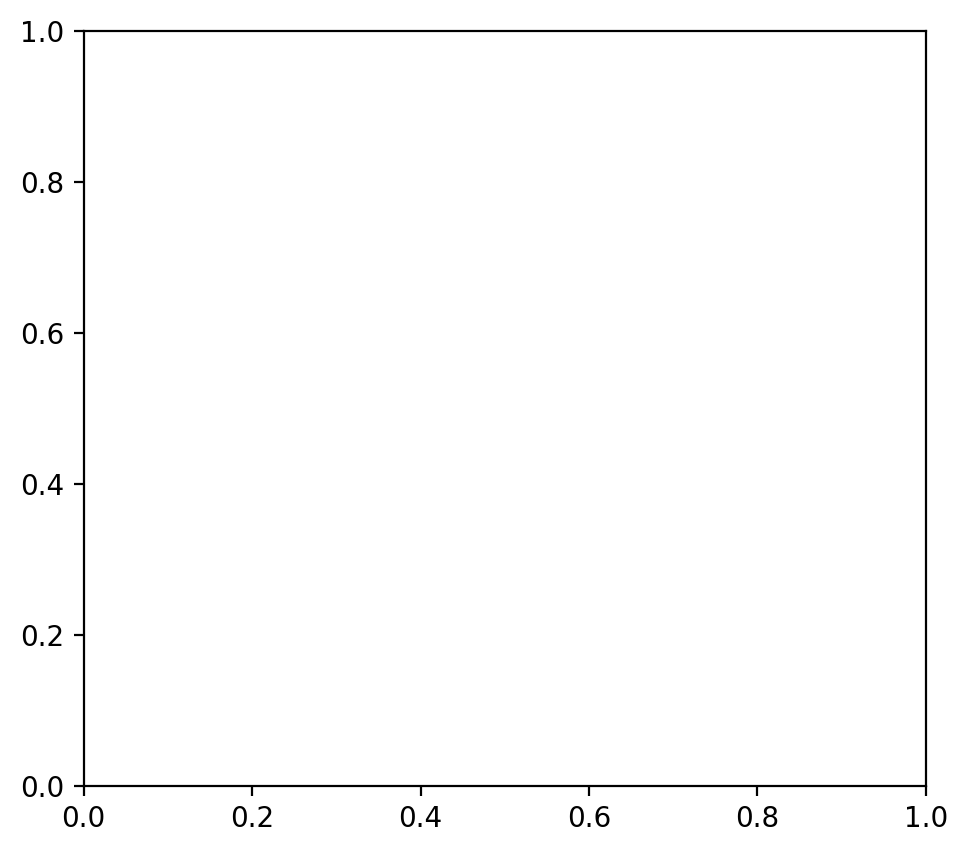

In [35]:
regtag = ['equatorial', 'transition', 'central', 'southern']
dics = [eq_ts, tr_ts, ce_ts, so_ts]
f = plt.figure(figsize=(25,5), dpi=200)

mind = 0


for ids, dic in enumerate(dics):
    
    
    ax = f.add_subplot(1,4,ids+1)
    qq = (dic['q_low']-dic['q_low'][mind])*1000#/ np.std(dic['q_low'])
    ws = np.sqrt(np.array(dic['u_mid'])**2 + np.array(dic['v_mid'])**2)
    ws = (ws-ws[mind])#/ np.std(ws)
    tt = (dic['tcw_low']-dic['tcw_low'][mind])#/ np.std(dic['tcw_low'])
    
#     if ids == 1:
#         qq[1::] = qq[1::]+1
#         ws[1::] = ws[1::]+1
#     if ids == 3:
#         tt[2:4] = tt[2:4]-1.2
        
    ax.plot(np.arange(len(dic['u_up']))-4,qq, marker='o', label='900hPa q', ms=3, color=cmap(9))
    ax.plot(np.arange(len(dic['u_up']))-4, tt, label='TCW', marker='o', ms=3, color=cmap(0))
    #ax.plot((dic['tcw_up']-dic['tcw_up'][mind])/ np.std(dic['tcw_up']), label='tcw_up', marker='o')
    #ax.plot((dic['prcp']-dic['prcp'][mind])/ np.std(dic['prcp']), label='prcp', marker='o')
    
    #ax.plot(np.arange(len(dic['prcp']))-4,(dic['prcp']-dic['prcp'][mind])/ np.std(dic['prcp']), label='Prcp', marker='o', ms=3, color='k')
    #ax.plot(np.arange(len(dic['prcp_e']))-4,(dic['prcp_e']-dic['prcp_e'][mind])/ np.std(dic['prcp_e']), label='Prcp_e', marker='o', ms=3, color='brown')
    #ax.plot(np.arange(len(dic['w_mid']))-4,(dic['w_up']-dic['w_up'][mind])/ np.std(dic['w_up']), label='w_mid', marker='o', ms=3, color='brown')
    
    
    
    
    

#     if regtag[ids] == 'southern':
#         ax.plot((dic['u_mid']-dic['u_mid'][mind])/ np.std(dic['u_mid']-dic['u_mid'][mind]), label='jet', marker='o')
#     else:
#         ax.plot(((dic['v_mid']-dic['v_mid'][mind])/ np.std(dic['v_mid']-dic['v_mid'][mind])), label='jet', marker='o')
    ax2 = ax.twinx()
    ax.plot(np.arange(len(dic['u_up']))-4, ws, label='900hPa jet', marker='o', ms=3, color=cmap(8))
    #ax2 = ax.twinx()
    ax2.plot(np.arange(len(dic['u_up']))-4, (dic['u_up']-dic['u_up'][mind]), color=cmap(2), marker='o', ms=3, label='200hPa u-wind')
    
#     ax.axvline(4*8+5, color='grey')
#     ax.axvline(4*8+2, color='k', linestyle='dashed')
    ax.axvline(0, color='k', linestyle='dashed')
    ax.axhline(0, color='k', linestyle='dashed')
    ax.set_ylim(-1,1)
    ax2.set_ylim(-3,3)
    
    bottom, top = ax.get_ylim()
    ax.add_patch(patches.Rectangle((-0.1, bottom),2.2, top-bottom, color='lightgrey', alpha=0.4, zorder=0, edgecolor=None))
#     ax.axvline(4+5, color='k', linestyle='dashed')
    ax.set_ylabel(r'Normalised difference from $t_{-4}$')

  
   # ax2.set_ylim(-4,4)
    if ids == 0:
        ax.legend(loc='upper left')
    plt.title(regtag[ids])

wetlen 430 drylen 622
wetlen 427 drylen 576
wetlen 426 drylen 349
wetlen 101 drylen 143


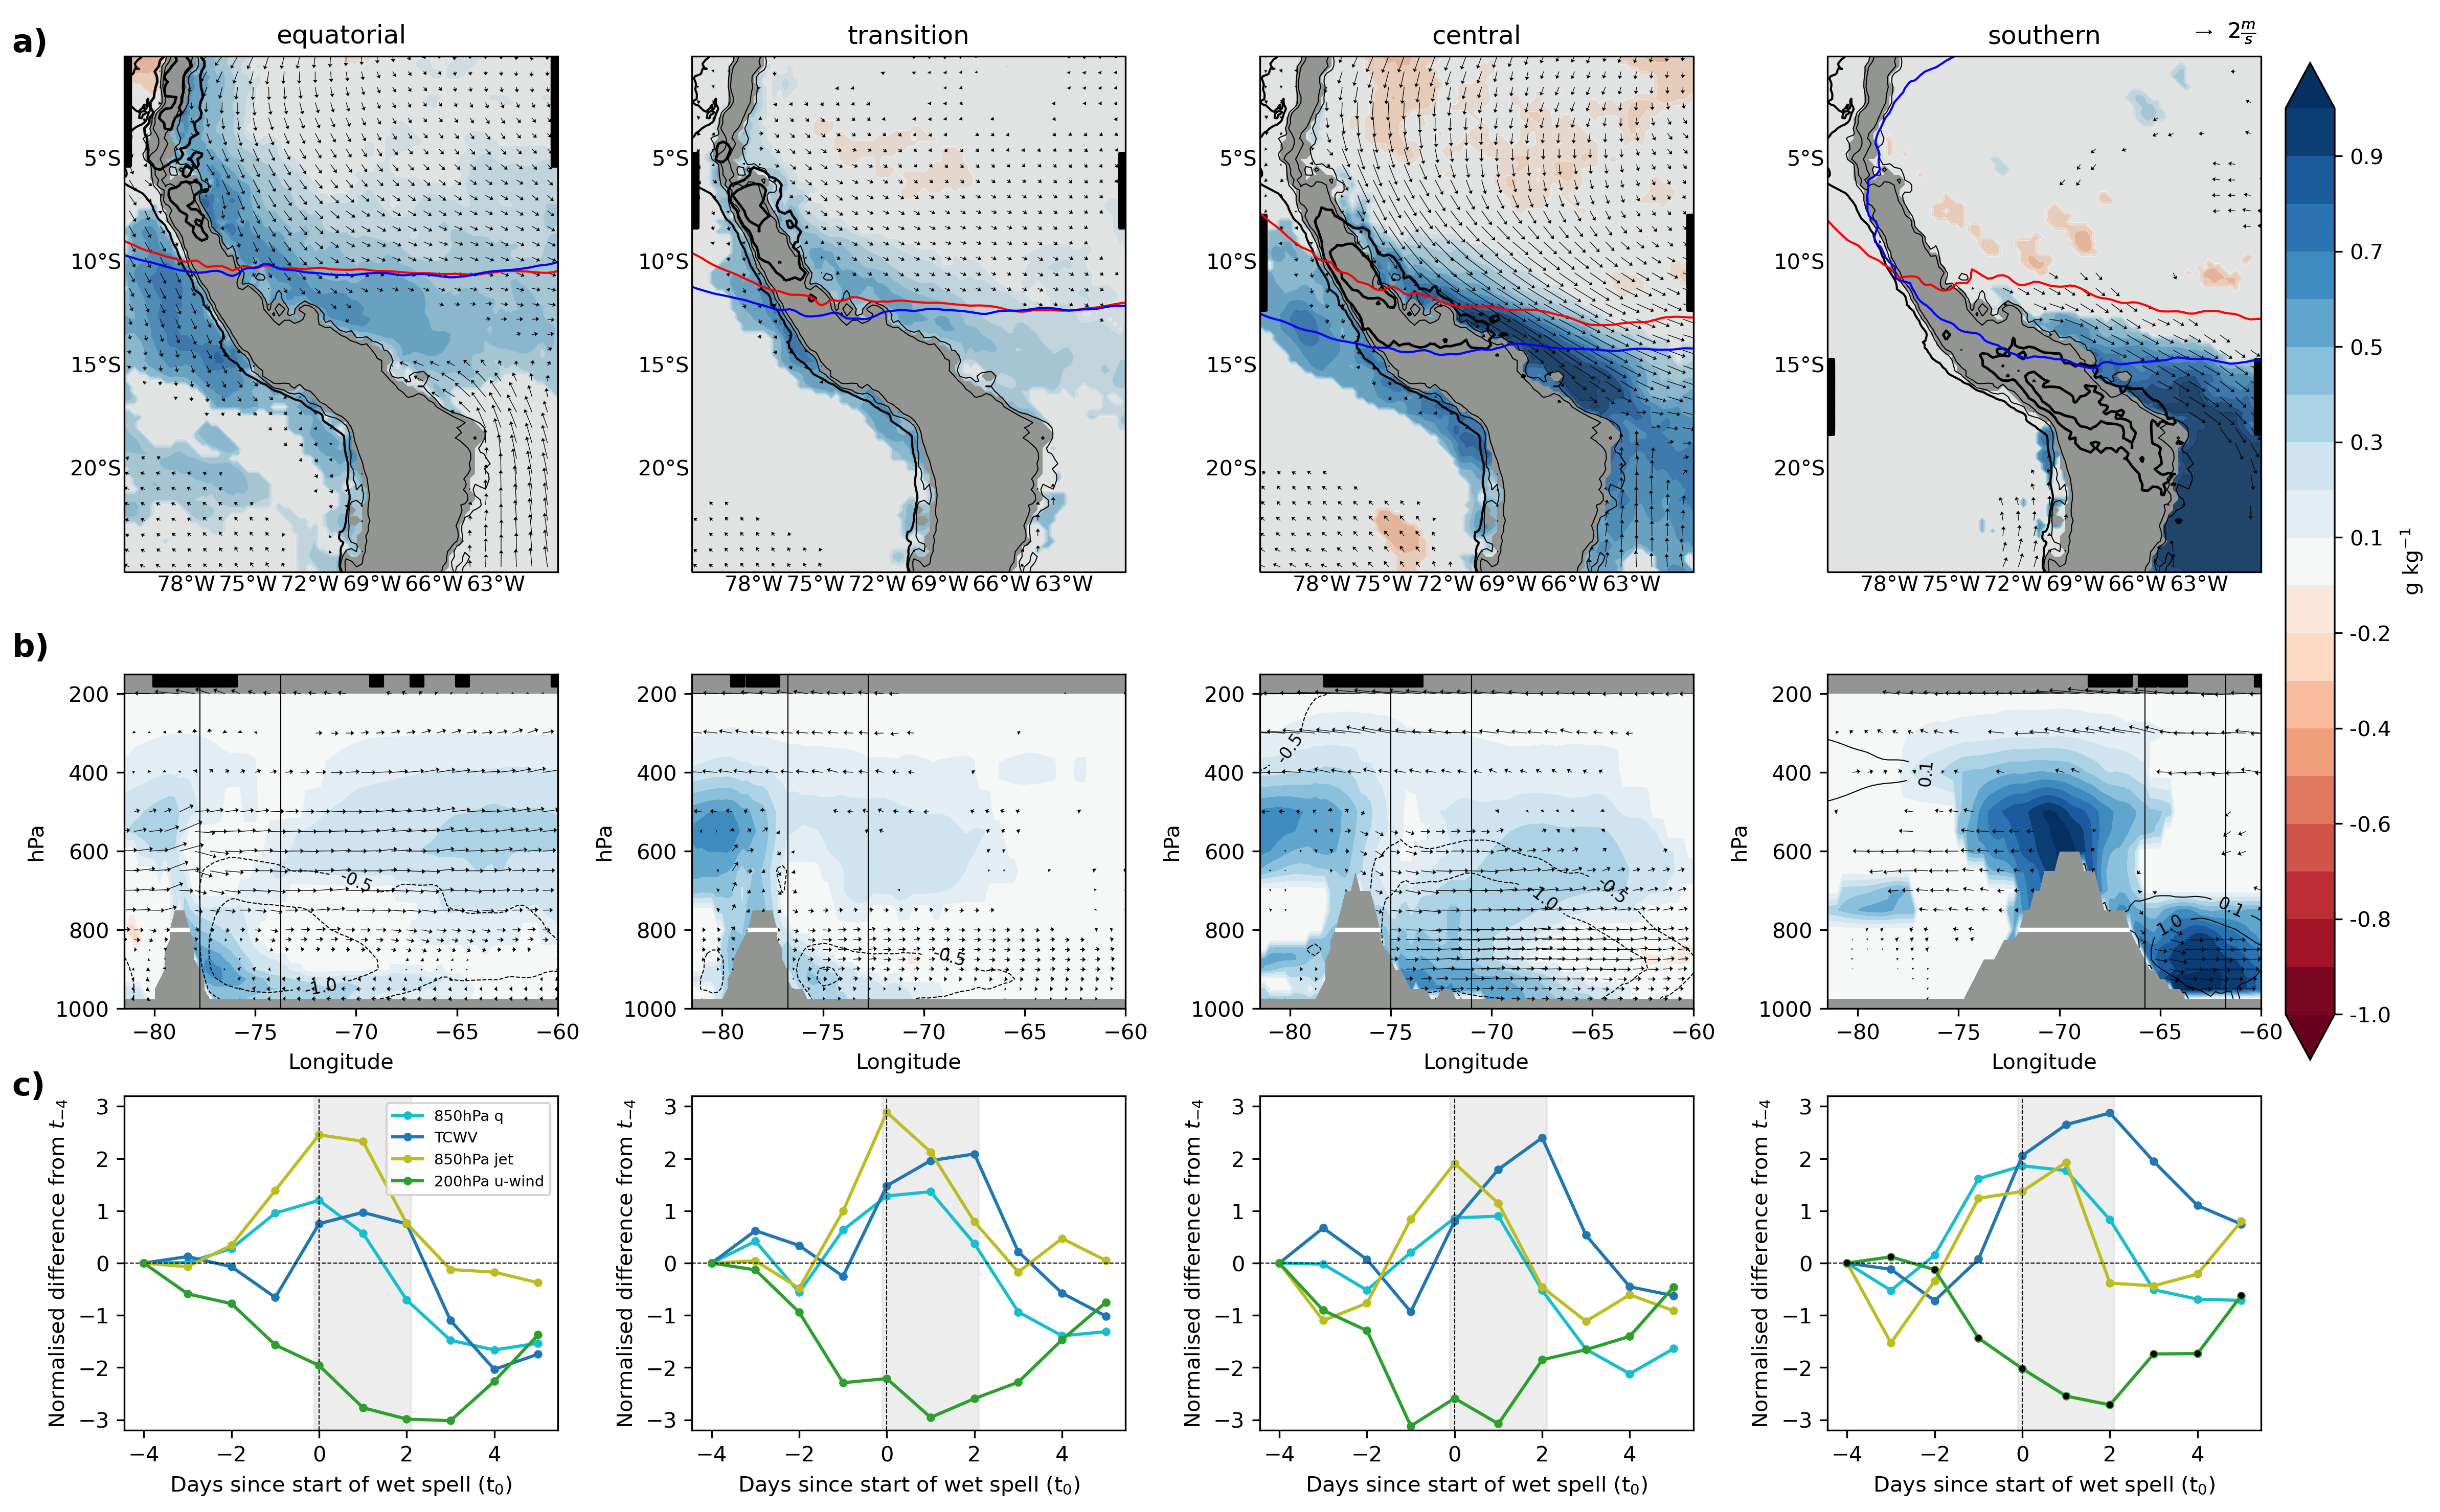

In [52]:
ml = 0.5
lonsample=[(-78.25+ml, -73.75), (-77.25+ml, -72.75), (-75.5+ml, -71.0), (-66.25+ml, -61.75)]

# slices_months = [ ('3d equatorial DRY', equatorial_dic['wet'], equatorial_dic['wet_ttest'],equatorial_dic['wet_doyclim'], equatorial_dic['wet_doyclim_ttest']),
#                   ('3d transition DRY', transition_dic['wet'], transition_dic['wet_ttest'],transition_dic['wet_doyclim'], transition_dic['wet_doyclim_ttest']),
#                  ('3d central DRY', central_dic['wet'], central_dic['wet_ttest'],central_dic['wet_doyclim'], central_dic['wet_doyclim_ttest']),   #dry_clim_allc.mean('time')
#                  ('3w southern DRY',southern_dic['wet'], southern_dic['wet_ttest'],southern_dic['wet_doyclim'], southern_dic['wet_doyclim_ttest']) ]  # mean_wet3, all_wet3, doy_wetclim3, wet_clim_all) ]


# slices_months = [ ('3d equatorial DRY', equatorial_dic['wet'], equatorial_dic['wet_ttest'],equatorial_dic['mean_clim'], equatorial_dic['all_clim']),
#                   ('3d transition DRY', transition_dic['wet'], transition_dic['wet_ttest'],transition_dic['mean_clim'], transition_dic['all_clim']),
#                  ('3d central DRY', central_dic['wet'], central_dic['wet_ttest'],central_dic['mean_clim'], central_dic['all_clim']),   #dry_clim_allc.mean('time')
#                  ('3w southern DRY',southern_dic['wet'], southern_dic['wet_ttest'],southern_dic['mean_clim'], southern_dic['all_clim']) ]  # mean_wet3, all_wet3, doy_wetclim3, wet_clim_all) ]

# slices_months = [ ('3d equatorial DRY', equatorial_dic['dry'], equatorial_dic['dry_ttest'],equatorial_dic['dry_doyclim'], equatorial_dic['dry_doyclim_ttest']),
#                   ('3d transition DRY', transition_dic['dry'], transition_dic['dry_ttest'],transition_dic['dry_doyclim'], transition_dic['dry_doyclim_ttest']),
#                  ('3d central DRY', central_dic['dry'], central_dic['dry_ttest'],central_dic['dry_doyclim'], central_dic['dry_doyclim_ttest']),   #dry_clim_allc.mean('time')
#                  ('3w southern DRY',southern_dic['dry'], southern_dic['dry_ttest'],southern_dic['dry_doyclim'], southern_dic['dry_doyclim_ttest']) ]  

slices_months = [ ('3d equatorial DRY', equatorial_dic['wet'], equatorial_dic['wet_ttest'],equatorial_dic['dry'], equatorial_dic['dry_ttest']),
                  ('3d transition DRY', transition_dic['wet'], transition_dic['wet_ttest'],transition_dic['dry'], transition_dic['dry_ttest']),
                 ('3d central DRY', central_dic['wet'], central_dic['wet_ttest'],central_dic['dry'], central_dic['dry_ttest']),   #dry_clim_allc.mean('time')
                 ('3w southern DRY',southern_dic['wet'], southern_dic['wet_ttest'],southern_dic['dry'], southern_dic['dry_ttest']) ]  # mean_wet3, all_wet3, doy_wetclim3, wet_clim_all) ]


# slices_months = [ ('3d equatorial DRY', equatorial_dic_n1['wet'], equatorial_dic_n1['wet_ttest'],equatorial_dic_n1['wet_doyclim'], equatorial_dic_n1['wet_doyclim_ttest']),
#                   ('3d transition DRY', transition_dic_n1['wet'], transition_dic_n1['wet_ttest'],transition_dic_n1['wet_doyclim'], transition_dic_n1['wet_doyclim_ttest']),
#                  ('3d central DRY', central_dic_n1['wet'], central_dic_n1['wet_ttest'],central_dic_n1['wet_doyclim'], central_dic_n1['wet_doyclim_ttest']),   #dry_clim_allc.mean('time')
#                  ('3w southern DRY',southern_dic_n1['wet'], southern_dic_n1['wet_ttest'],southern_dic_n1['wet_doyclim'], southern_dic_n1['wet_doyclim_ttest']) ]  # mean_wet3, all_wet3, doy_wetclim3, wet_clim_all) ]


wet_rscat = {'q' : [], 'u2' : [], 'u8' : [], 'v8' : []}
dry_rscat = {'q' : [], 'u2' : [], 'u8' : [], 'v8' : []}

#f = plt.figure(figsize=(18,14), dpi=300)
f = plt.figure(figsize=(16,10), dpi=300)
gs = f.add_gridspec(7,4)
cnt = 0
cnt2=0
for ids in range(9):
    
    if ids in [0,1,2,3]:
        #ax1 = f.add_subplot(3,4,ids+1, projection=ccrs.PlateCarree())
        
        ax1 = f.add_subplot(gs[0:3,ids], projection=ccrs.PlateCarree())
        
        alls = regions[list(regions.keys())[ids]][0]
        
        ax1 = map_2d(ax1, toreg[cnt2])
#         ax1.axhline(alls[0], color='grey')
#         ax1.axhline(alls[1], color='grey')
        
        
        domlats = height.sel(latitude=slice(alls[0],alls[1])).latitude.values
        domlons = -60 #height.longitude.max().values
        domlons2 = -81
        #ipdb.set_trace()
        ax1.scatter([float(domlons)]*domlats.size, domlats, color='k', marker='s')
        ax1.scatter([float(domlons2)]*domlats.size, domlats, color='k', marker='s')
        
        
        cnt2 = cnt2+1
            
        if ids == 6:
            xlab = 'Longitude'
        else:
            xlab = ''
        
        plt.ylabel('Latitude')
        plt.xlabel(xlab)
    
    
    if  ids in [4,5,6,7]:
        
        dd = slices_months[cnt]
        
        slices = dd[1] # d/w mean
        tag = dd[0]

        slices_ttest = dd[2] #  d/w all, for day-wise t-test, all days versus only wet/dry
        slice_clim = dd[3] # doy d/w clim
        clim_ttest = dd[4]

        # "current zonal wind" wind vectors
        #ipdb.set_trace()
        vano = slices['u']
        wano = slices['w']*(-10)  # multiplied by 10 since vertical component is very small compared to horizontal one
        vclim = slice_clim['u']
        wclim = slice_clim['w']*(-10)
        st=2
        stt = 3
        sarrow = 1
        xquiv = slices.longitude[sarrow::stt]
        yquiv = slices.level

        uu = (vano)#[::, sarrow::stt]  
        ww = (wano)#[::, sarrow::stt]
        uuc = (vclim)#[::, sarrow::stt]  
        wwc = (wclim)#[::, sarrow::stt] 
        utstat, upval = stats.ttest_ind(slices_ttest['u'], clim_ttest['u'], axis=0, equal_var=False)
        umask = upval<=0.05

        wtstat, wpval = stats.ttest_ind(slices_ttest['w'], clim_ttest['w'], axis=0, equal_var=False)
        
        wmask = wpval<=0.05
        if ids in [5,7]:
            wmask = wpval<=0.15
        
        vtstat, vpval = stats.ttest_ind(slices_ttest['v'], clim_ttest['v'], axis=0, equal_var=False)
        vmask = vpval<=0.05

        bothmask = wmask | umask #| wmask[::, sarrow::stt] 
        #ipdb.set_trace()


        uu = uu-uuc
        ww = ww-wwc
        uu = uu.where(bothmask)
        ww = ww.where(bothmask)
        
        eastpos = np.where((uu.values[1,:])<0)
        
        #ipdb.set_trace()
        
        uu = uu[::, sarrow::stt]
        ww = ww[::, sarrow::stt]

        qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : ww, 'scale' : 40}

        # temperature and moisture check

        var3 = 'd'
        data3 = (slices[var3])*1500000 # #- slice_clim[var] - slice_clim[var]
        a3= slices_ttest[var3] 
        b3= clim_ttest[var3]
        tstat3, pval3= stats.ttest_ind(a3, b3, axis=0)
        mask3= pval3<=0.05

        data3.values[(~mask3)] = 0

        dpos = np.where((data3.values[0,:])>5)
        
        

        #ipdb.set_trace()

        var = 'q'
        var2 = 'q'
        data2 = (slices[var]- slice_clim[var])*1000 # 
        a = slices_ttest[var2] 
        b = clim_ttest[var2]
        tstat, pval = stats.ttest_ind(a, b, axis=0)
        mask = pval<=0.05
        #ipdb.set_trace()
        data2.values[(~mask) & (np.isfinite(data2.values)) ] = 0 # & (np.isfinite(data2.values)

        data = slices['v']-slice_clim['v'] #+ ((slices['v']-slice_clim['v']))
        data4 = slices['u']-slice_clim['u']
        
        data5 = np.sqrt(data**2+data4**2)
#         wswet = np.sqrt(slices_ttest['u']**2+slices_ttest['v']**2)
#         wsdry = np.sqrt(clim_ttest['u']**2+clim_ttest['v']**2)
        
        #wsstat, wspval = stats.ttest_ind(wswet,wsdry, axis=0, equal_var=False)
        #wsmask = wspval<=0.05
        
        #data5.values[(~wsmask)] = 0

        
        #ax = f.add_subplot(3,4,ids+1)
        ax = f.add_subplot(gs[3:5,ids-4])
        
        conlev = [-1,-0.5]
        if cnt==3:
            data = data4
            conlev = [0.1,1]
            
        lowlev = 900
        
        ppos = np.where(np.isnan(data2.sel(level=lowlev).values))[0]
        ppos8 = ppos[-1]
        

        
        q850pick = slices_ttest['q'].sel(level=lowlev).isel(longitude=slice(ppos8+1,ppos8+5)).mean('longitude').values
        v850pick = slices_ttest['v'].sel(level=lowlev).isel(longitude=slice(ppos8+4,ppos8+19)).mean('longitude').values
        u200pick = slices_ttest['u'].sel(level=200).isel(longitude=slice(ppos[0],ppos[-1])).mean('longitude').values
        u850pick = slices_ttest['u'].sel(level=lowlev).isel(longitude=slice(ppos8+4,ppos8+19)).mean('longitude').values
        
        wet_rscat['q'].append(q850pick)
        wet_rscat['v8'].append(v850pick)
        wet_rscat['u8'].append(u850pick)
        wet_rscat['u8'].append(v850pick)
        wet_rscat['u2'].append(u200pick)
        
        q850pick = clim_ttest['q'].sel(level=lowlev).isel(longitude=slice(ppos8+1,ppos8+5)).mean('longitude').values
        v850pick = clim_ttest['v'].sel(level=lowlev).isel(longitude=slice(ppos8+4,ppos8+19)).mean('longitude').values
        u200pick = clim_ttest['u'].sel(level=200).isel(longitude=slice(ppos[0],ppos[-1])).mean('longitude').values
        u850pick = clim_ttest['u'].sel(level=lowlev).isel(longitude=slice(ppos8+4,ppos8+19)).mean('longitude').values
        
        dry_rscat['q'].append(q850pick)
        dry_rscat['v8'].append(v850pick)
        dry_rscat['u8'].append(u850pick)
        dry_rscat['u8'].append(v850pick)
        dry_rscat['u2'].append(u200pick)
        
        ppos = np.where(np.isnan(data2.sel(level=lowlev).values))[0]
        ppos8 = ppos[-1]
        #data2.values[11,ppos8+4:ppos8+19] = 1000
        lon1 = lonsample[ids-4][0]
        lon2 = lonsample[ids-4][1]
        

        
                        
        #ipdb.set_trace()
        
        #data2.values[11,ppos8+4:ppos8+19] = 1000

        contour = {'data' : data, 'x' :slices.longitude, 'y' : slices.level, 'levels' : conlev, 'colours' : 'k'}  #np.arange(335,355, 1)
        #contour = {'data' : data3, 'x' :slices.longitude, 'y' : slices.level, 'levels' : [8,10], 'colours' : 'k'}

        xlab = 'Longitude'
        
        #  #levels=np.arange(-1,2,0.1)

        mapp = draw_cross(ax, data2, slices.longitude, slices.level, ylabel = 'hPa', xlabel=xlab,cmap='RdBu', quiver=qin, contour=contour,levels=np.linspace(-1,1,20) ,cbar=False, cbar_label='g kg$^{-1}$') #np.arange(-2, 2.1, 0.25)  #Spectral
        
#         if ids in [0,1]:
#             cl = 1.7
#         else:
#             cl = 3.5
        
#         ax.contour(slices.longitude, slices.level, np.sqrt(slices['u']**2+slices['v']**2), levels=[-50,cl], colors='b')
#         ax.contour(slices.longitude, slices.level, np.sqrt(slice_clim['u']**2+slice_clim['v']**2), levels=[-50,cl], colors='r')
        xx1=[]
        xx2=[]
        pplevs = []
        for plev in [800]: #, 750, 700, 650, 600
            mpos = np.where(np.isnan(data2.sel(level=plev)))
            try:
                xx1.append(slices.longitude.values[mpos[0][0]-1])
                xx2.append(slices.longitude.values[mpos[0][-1]+1])
            except:
                continue
            
            pplevs.append(plev)
            

        
  
        #ax.contour(slices.longitude, slices.level, data4, levels=[1,2,5], colors='purple', linewidths=1)
        #ipdb.set_trace()
        ax.scatter(slices.longitude[dpos[0]], [165]*len(dpos[0]), color='k', marker='s')
        ax.axvline(lon1, color='k', linewidth=0.5)
        ax.axvline(lon2, color='k', linewidth=0.5)
        #ax.scatter(slices.longitude[eastpos[0]], [200]*len(eastpos[0]), color='red', marker='s')
        ax.set_facecolor('xkcd:grey') #xkcd:grey
        ax.hlines(pplevs ,xx1, xx2, color='white', linewidth=2, zorder=99)
        #ax.hlines(800, xmin=-80, xmax=-75, color='red', linewidth=10, zorder=99)
        ax.set_ylim(1000, 150)
        ax.set_xlim(-81.5, -60)
        cnt = cnt+1
        


########################################################################################
########################################################################################

regtag = ['equatorial', 'transition', 'central', 'southern']
dics = [eq_ts, tr_ts, ce_ts, so_ts]

mind = 0
cmap = plt.get_cmap("tab10")


for ids, dic in enumerate(dics):
    #ax = f.add_subplot(3,4,ids+9)
    
    qq = (dic['q_low']-dic['q_low'][mind])/ np.std(dic['q_low'])
    ws = np.sqrt(np.array(dic['u_mid'])**2 + np.array(dic['v_mid'])**2)
    ws = (ws-ws[mind])/ np.std(ws)
    tt = (dic['tcw_low']-dic['tcw_low'][mind])/ np.std(dic['tcw_low'])
    
    if ids == 1:
        qq[1::] = qq[1::]+1
        ws[1::] = ws[1::]+1
    if ids == 3:
        tt[2:4] = tt[2:4]-1.2
    
    ax = f.add_subplot(gs[-2:, ids])
    
    ax.plot(np.arange(len(dic['u_up']))-4,qq, marker='o', label='850hPa q', ms=3, color=cmap(9))
    ax.plot(np.arange(len(dic['u_up']))-4,tt, label='TCWV', marker='o', ms=3, color=cmap(0))
    #ax.plot((dic['tcw_up']-dic['tcw_up'][mind])/ np.std(dic['tcw_up']), label='tcw_up', marker='o')
    #ax.plot((dic['prcp']-dic['prcp'][mind])/ np.std(dic['prcp']), label='prcp', marker='o')

#     if regtag[ids] == 'southern':
#         ax.plot((dic['u_mid']-dic['u_mid'][mind])/ np.std(dic['u_mid']-dic['u_mid'][mind]), label='jet', marker='o')
#     else:
#         ax.plot(((dic['v_mid']-dic['v_mid'][mind])/ np.std(dic['v_mid']-dic['v_mid'][mind])), label='jet', marker='o')
    ax.plot(np.arange(len(dic['u_up']))-4,ws, label='850hPa jet', marker='o', ms=3, color=cmap(8))
    #ax2 = ax.twinx()
    
    windmap = np.array([cmap(2)]*len(dic['u_up']))
    neg = (np.array(dic['u_up']) > 0)
    windmap[neg] =  (0.0, 0.0, 0.0, 1.0) #cmap(5)
   # ipdb.set_trace()
    ax.plot(np.arange(len(dic['u_up']))-4, (dic['u_up']-dic['u_up'][mind])/ np.std((dic['u_up'])), color=cmap(2), marker='o', ms=3, label='200hPa u-wind')
    ax.scatter(np.arange(len(dic['u_up']))-4, (dic['u_up']-dic['u_up'][mind])/ np.std((dic['u_up'])), c=windmap, s=4, zorder=90)
    
#     ax.axvline(4*8+5, color='grey')
#     ax.axvline(4*8+2, color='k', linestyle='dashed')
    ax.axvline(0, color='k', linestyle='dashed', linewidth=0.5)
    ax.axhline(0, color='k', linestyle='dashed', linewidth=0.5)
    ax.set_ylim(-3.2,3.2)
    
    bottom, top = ax.get_ylim()
    ax.add_patch(patches.Rectangle((-0.1, bottom),2.2, top-bottom, color='lightgrey', alpha=0.4, zorder=0, edgecolor=None))
#     ax.axvline(4+5, color='k', linestyle='dashed')
    ax.set_ylabel(r'Normalised difference from $t_{-4}$')
    ax.set_xlabel(r'Days since start of wet spell (t$_0$)')

  
   # ax2.set_ylim(-4,4)
    if ids == 0:
        ax.legend(fontsize=7, loc='upper right')
    ax.set_title('', fontsize=13)
#############################################



plt.subplots_adjust(wspace=0.11, hspace=0.15)   
plt.tight_layout()

f.subplots_adjust(right=0.92)
cax = f.add_axes([0.93,0.3,0.02,0.65])
cbar = f.colorbar(mapp, cax, format='%1.1f',label=r'g kg$^{-1}$')

plt.annotate('a)', xy=(0.005, 0.96), xytext=(0, 4), size=15, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points', fontweight='bold')
plt.annotate('b)', xy=(0.005, 0.56), xytext=(0, 4), size=15, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points', fontweight='bold')
plt.annotate('c)', xy=(0.005, 0.27), xytext=(0, 4), size=15, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points', fontweight='bold')


f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/paper/drywet_cross_map_windLegend.jpg')

wetlen 642 drylen 1057
wetlen 650 drylen 1002
wetlen 714 drylen 597
wetlen 216 drylen 271


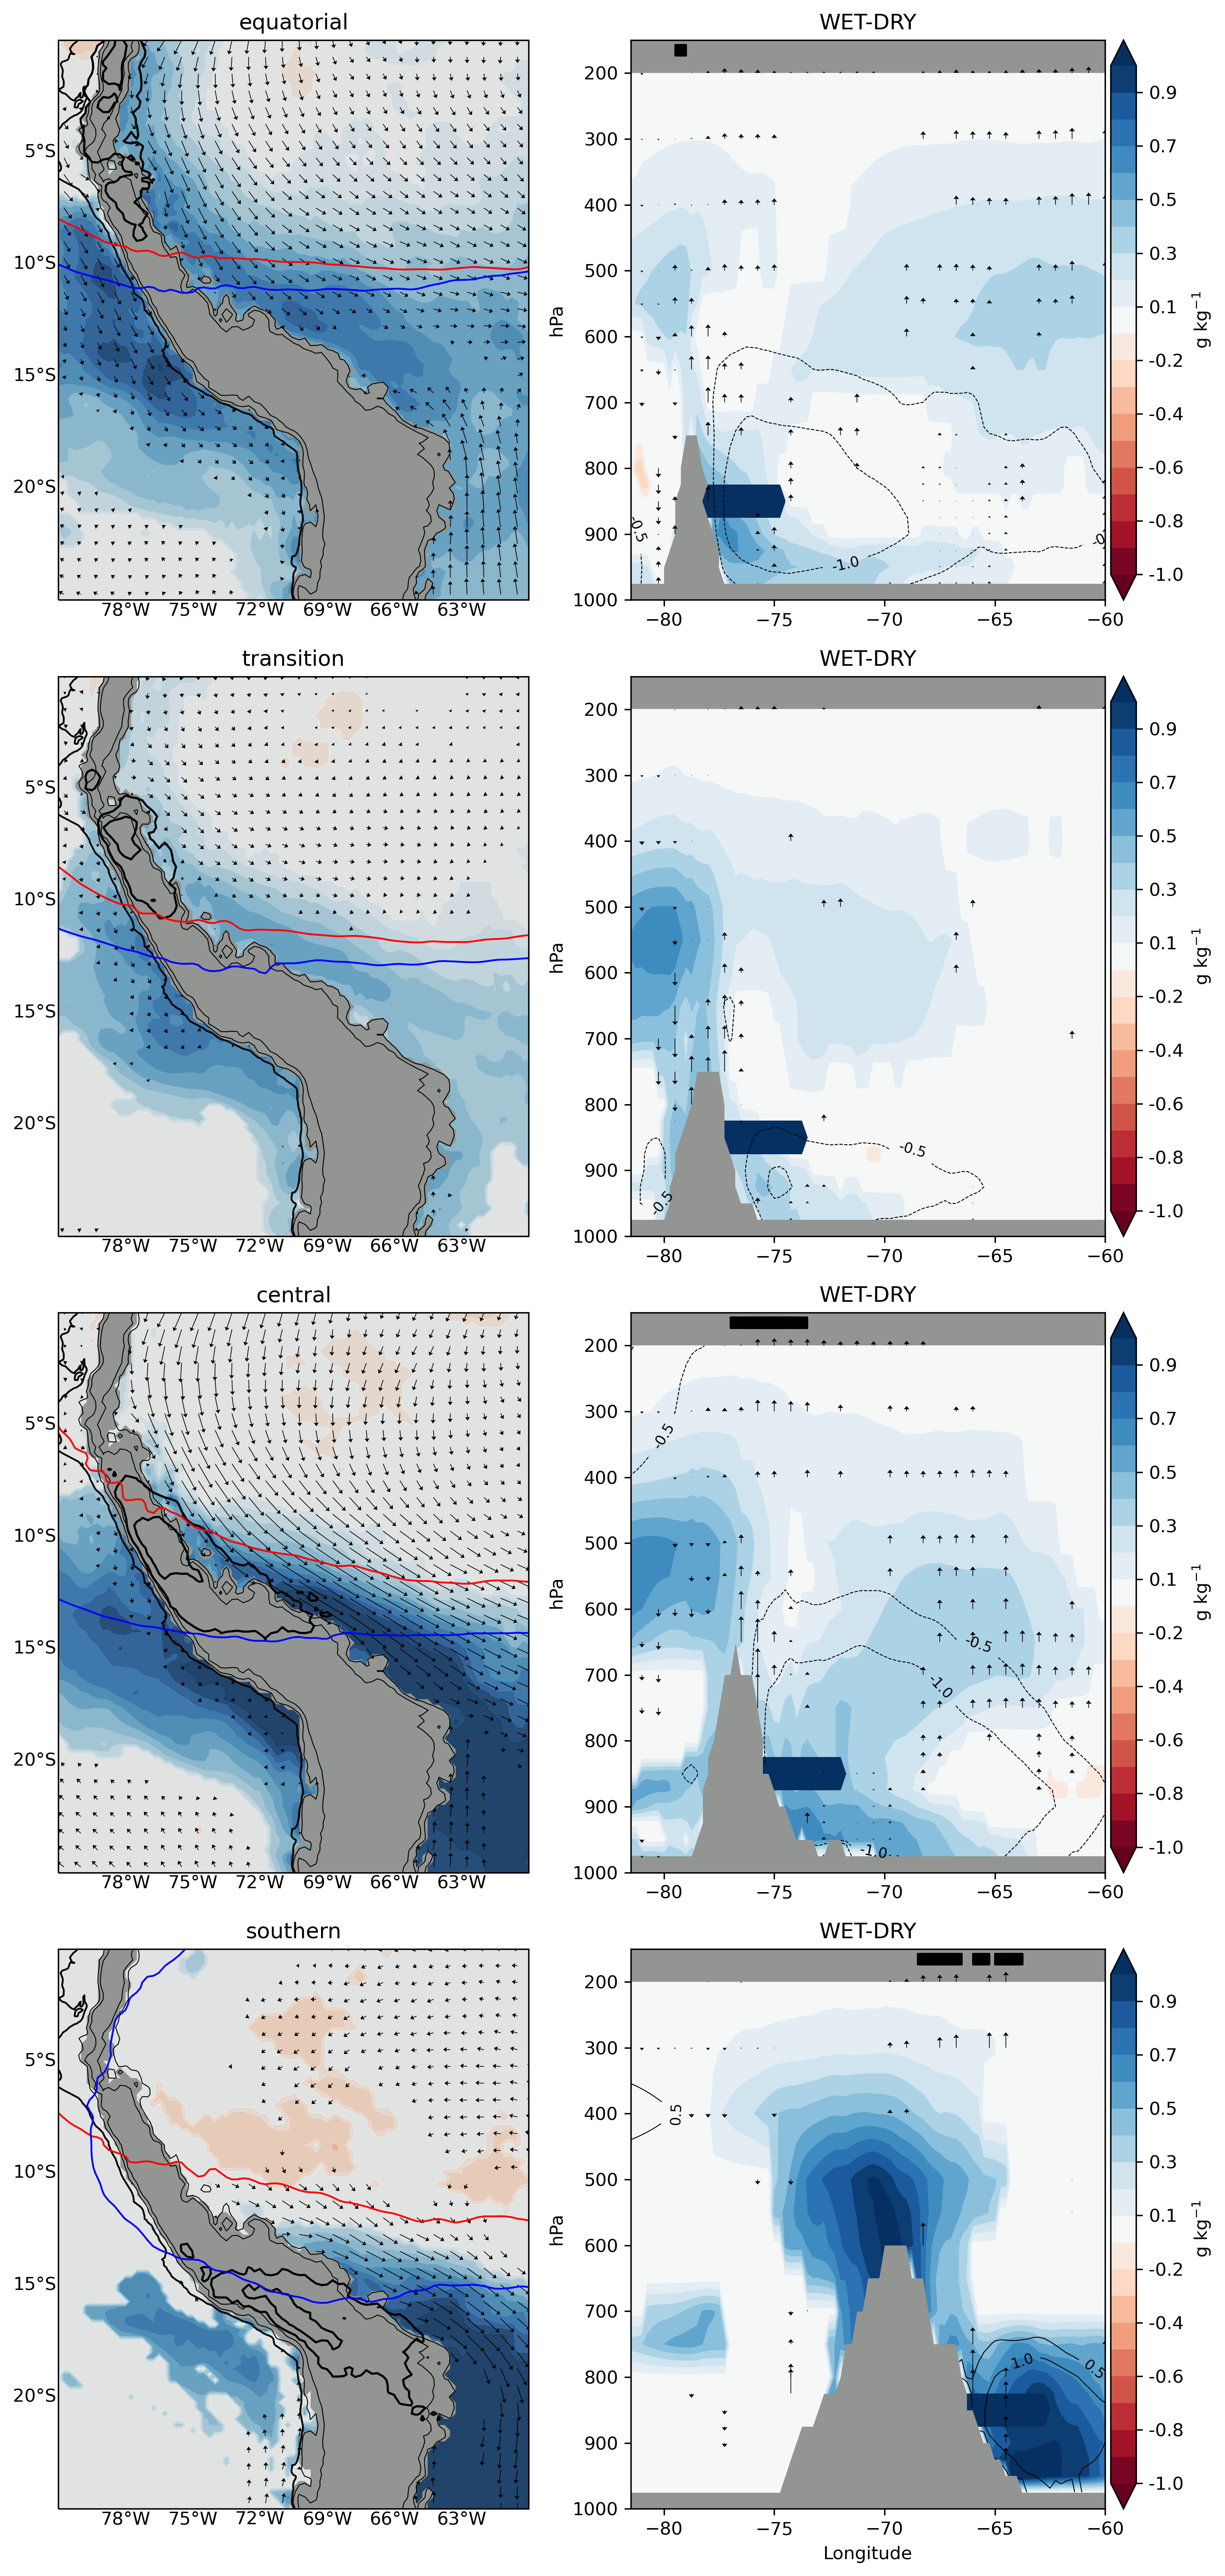

In [43]:
slices_months = [ ('3d equatorial DRY', equatorial_dic['wet'], equatorial_dic['wet_ttest'],equatorial_dic['dry'], equatorial_dic['dry_ttest'], equatorial_dic['all_clim']),
                  ('3d transition DRY', transition_dic['wet'], transition_dic['wet_ttest'],transition_dic['dry'], transition_dic['dry_ttest'], transition_dic['all_clim']),
                 ('3d central DRY', central_dic['wet'], central_dic['wet_ttest'],central_dic['dry'], central_dic['dry_ttest'], central_dic['all_clim']),   #dry_clim_allc.mean('time')
                 ('3w southern DRY',southern_dic['wet'], southern_dic['wet_ttest'],southern_dic['dry'], southern_dic['dry_ttest'] , southern_dic['all_clim'])]  # mean_wet3, all_wet3, doy_wetclim3, wet_clim_all) ]


wet_rscat = {'q' : [], 'u2' : [], 'u8' : [], 'v8' : [], 'w5' : []}
dry_rscat = {'q' : [], 'u2' : [], 'u8' : [], 'v8' : [], 'w5' : []}
clim_rscat = {'q' : [], 'u2' : [], 'u8' : [], 'v8' : [], 'w5' : []}

lonsample = []

f = plt.figure(figsize=(10,20), dpi=300)
cnt = 0
cnt2=0
for ids in range(9):
    
    if ids in [0,2,4,6]:
        ax1 = f.add_subplot(4,2,ids+1, projection=ccrs.PlateCarree())
        
        ax1 = map_2d(ax1, toreg[cnt2])
        cnt2 = cnt2+1
            
        if ids == 6:
            xlab = 'Longitude'
        else:
            xlab = ''
        
        plt.ylabel('Latitude')
        plt.xlabel(xlab)
    
    
    if ids in [1,3,5,7]:
        
        dd = slices_months[cnt]
        
        slices = dd[1] # d/w mean
        tag = dd[0]

        slices_ttest = dd[2] #  d/w all, for day-wise t-test, all days versus only wet/dry
        slice_clim = dd[3] # doy d/w clim
        clim_ttest = dd[4]
        
        allclim = dd[5]

        # "current zonal wind" wind vectors
        #ipdb.set_trace()
        vano = slices['u']
        wano = slices['w']*(-20)  # multiplied by 10 since vertical component is very small compared to horizontal one
        vclim = slice_clim['u']
        wclim = slice_clim['w']*(-20)
        st=2
        stt = 3
        sarrow = 1
        xquiv = slices.longitude[sarrow::stt]
        yquiv = slices.level

        uu = (vano)[::, sarrow::stt]  
        ww = (wano)[::, sarrow::stt]
        uuc = (vclim)[::, sarrow::stt]  
        wwc = (wclim)[::, sarrow::stt] 
        utstat, upval = stats.ttest_ind(slices_ttest['u'], clim_ttest['u'], axis=0, equal_var=False)
        umask = upval<=0.05

        wtstat, wpval = stats.ttest_ind(slices_ttest['w'], clim_ttest['w'], axis=0, equal_var=False)
        wmask = wpval<=0.05
        
        vtstat, vpval = stats.ttest_ind(slices_ttest['v'], clim_ttest['v'], axis=0, equal_var=False)
        vmask = vpval<=0.05

        bothmask = wmask[::, sarrow::stt] #| wmask[::, sarrow::stt] 
        #ipdb.set_trace()


        uu = uu#-uuc
        ww = ww#-wwc
        uu = uu.where(bothmask)
        ww = ww.where(bothmask)

        qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu*0, 'v' : ww, 'scale' : 70}

        # temperature and moisture check

        var3 = 'd'
        data3 = (slices[var3])*1500000 # #- slice_clim[var] - slice_clim[var]
        a3= slices_ttest[var3] 
        b3= clim_ttest[var3]
        tstat3, pval3= stats.ttest_ind(a3, b3, axis=0)
        mask3= pval3<=0.05

        data3.values[(~mask3)] = 0

        dpos = np.where((data3.values[0,:])>10)

        #ipdb.set_trace()

        var = 'q'
        var2 = 'q'
        data2 = (slices[var]- slice_clim[var])*1000 # 
        a = slices_ttest[var2] 
        b = clim_ttest[var2]
        tstat, pval = stats.ttest_ind(a, b, axis=0)
        mask = pval<=0.05
        #ipdb.set_trace()
        data2.values[(~mask) & (np.isfinite(data2.values)) ] = 0 # & (np.isfinite(data2.values)

        data = slices['v']-slice_clim['v'] #+ ((slices['v']-slice_clim['v']))
        data4 = slices['u']-slice_clim['u']
        
        data5 = np.sqrt(data**2+data4**2)
#         wswet = np.sqrt(slices_ttest['u']**2+slices_ttest['v']**2)
#         wsdry = np.sqrt(clim_ttest['u']**2+clim_ttest['v']**2)
        
        #wsstat, wspval = stats.ttest_ind(wswet,wsdry, axis=0, equal_var=False)
        #wsmask = wspval<=0.05
        
        #data5.values[(~wsmask)] = 0

        
        ax = f.add_subplot(4,2,ids+1)
        
        conlev = [-1,-0.5]
        if cnt==3:
            data = data4
            conlev = [0.5,1]
        
        ppos = np.where(np.isnan(data2.sel(level=850).values))[0]
        ppos8 = ppos[-1]
        
        q850pick = slices_ttest['q'].sel(level=850).isel(longitude=slice(ppos8+1,ppos8+5)).mean('longitude').values
        v850pick = slices_ttest['v'].sel(level=850).isel(longitude=slice(ppos8+4,ppos8+19)).mean('longitude').values
        u200pick = slices_ttest['u'].sel(level=200).isel(longitude=slice(ppos[0],ppos[-1])).mean('longitude').values
        w550pick = slices_ttest['w'].sel(level=550).isel(longitude=slice(ppos[0],ppos[-1])).mean('longitude').values
        u850pick = slices_ttest['u'].sel(level=850).isel(longitude=slice(ppos8+4,ppos8+19)).mean('longitude').values
        
        wet_rscat['q'].append(q850pick)
        wet_rscat['v8'].append(v850pick)
        wet_rscat['u8'].append(np.sqrt(u850pick**2+v850pick**2))
        wet_rscat['u2'].append(u200pick)
        wet_rscat['w5'].append(w550pick)
        
        q850pick = clim_ttest['q'].sel(level=850).isel(longitude=slice(ppos8+1,ppos8+5)).mean('longitude').values
        v850pick = clim_ttest['v'].sel(level=850).isel(longitude=slice(ppos8+4,ppos8+19)).mean('longitude').values
        u200pick = clim_ttest['u'].sel(level=200).isel(longitude=slice(ppos[0],ppos[-1])).mean('longitude').values
        w550pick = clim_ttest['w'].sel(level=550).isel(longitude=slice(ppos[0],ppos[-1])).mean('longitude').values
        u850pick = clim_ttest['u'].sel(level=850).isel(longitude=slice(ppos8+4,ppos8+19)).mean('longitude').values
        
        dry_rscat['q'].append(q850pick)
        dry_rscat['v8'].append(v850pick)
        dry_rscat['u8'].append(np.sqrt(u850pick**2+v850pick**2))
        dry_rscat['u2'].append(u200pick)
        dry_rscat['w5'].append(w550pick)
        
        q850pick = allclim['q'].sel(level=850).isel(longitude=slice(ppos8+1,ppos8+5)).mean('longitude').values
        v850pick = allclim['v'].sel(level=850).isel(longitude=slice(ppos8+4,ppos8+19)).mean('longitude').values
        u200pick = allclim['u'].sel(level=200).isel(longitude=slice(ppos[0],ppos[-1])).mean('longitude').values
        w550pick = allclim['w'].sel(level=550).isel(longitude=slice(ppos[0],ppos[-1])).mean('longitude').values
        u850pick = allclim['u'].sel(level=850).isel(longitude=slice(ppos8+4,ppos8+19)).mean('longitude').values
        
        clim_rscat['q'].append(q850pick)
        clim_rscat['v8'].append(v850pick)
        clim_rscat['u8'].append(np.sqrt(u850pick**2+v850pick**2))
        clim_rscat['u2'].append(u200pick)
        clim_rscat['w5'].append(w550pick)
        
                        
        #ipdb.set_trace()
        
        #data2.values[11,ppos8+4:ppos8+19] = 1000
        data2.values[11,ppos8:ppos8+15] = 1000
        
        lonsample.append((np.min(data2.longitude[ppos8:ppos8+15].values), np.max(data2.longitude[ppos8+4:ppos8+19].values)))
        
        

        contour = {'data' : data, 'x' :slices.longitude, 'y' : slices.level, 'levels' : conlev, 'colours' : 'k'}  #np.arange(335,355, 1)
        #contour = {'data' : data3, 'x' :slices.longitude, 'y' : slices.level, 'levels' : [8,10], 'colours' : 'k'}
        if ids == 7:
            xlab = 'Longitude'
        else:
            xlab = ''
        draw_cross(ax, data2, slices.longitude, slices.level, ylabel = 'hPa', xlabel=xlab,cmap='RdBu', quiver=qin, cbar=True, contour=contour, cbar_label='g kg$^{-1}$', levels=np.linspace(-1,1,20), title='WET-DRY') #np.arange(-2, 2.1, 0.25)  #Spectral
        #ax.contour(slices.longitude, slices.level, data4, levels=[1,2,5], colors='purple', linewidths=1)
        #ipdb.set_trace()
        ax.scatter(slices.longitude[dpos[0]], [165]*len(dpos[0]), color='k', marker='s')
        ax.set_facecolor('xkcd:grey') #xkcd:grey
        ax.set_ylim(1000, 150)
        ax.set_xlim(-81.5, -60)
        cnt = cnt+1
        

plt.subplots_adjust(wspace=0.11)   
plt.tight_layout()

#f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/paper/drywet_cross_map.jpg')

In [ ]:
lonsample

In [51]:
f = plt.figure(figsize=(10,3), dpi=200)
ids = 1
for qw, qd, uw, ud in zip(wet_rscat['w5'],dry_rscat['w5'], wet_rscat['u2'],dry_rscat['u2']):

    ax = f.add_subplot(1,4,ids)
    ax.scatter(qw, uw, color='blue')
    ax.scatter(qd, ud, color='red', alpha=0.5)
    
    ids = ids+1

KeyError: 'w5'

<Figure size 2000x600 with 0 Axes>

Ttest_indResult(statistic=-5.542535035023416, pvalue=3.891843581441616e-08)
Ttest_indResult(statistic=-3.5295090366987467, pvalue=0.0004500798293471994)
Ttest_indResult(statistic=-7.89807926807758, pvalue=1.0597566333427646e-14)
Ttest_indResult(statistic=-0.15163128329175743, pvalue=0.8796144331899354)


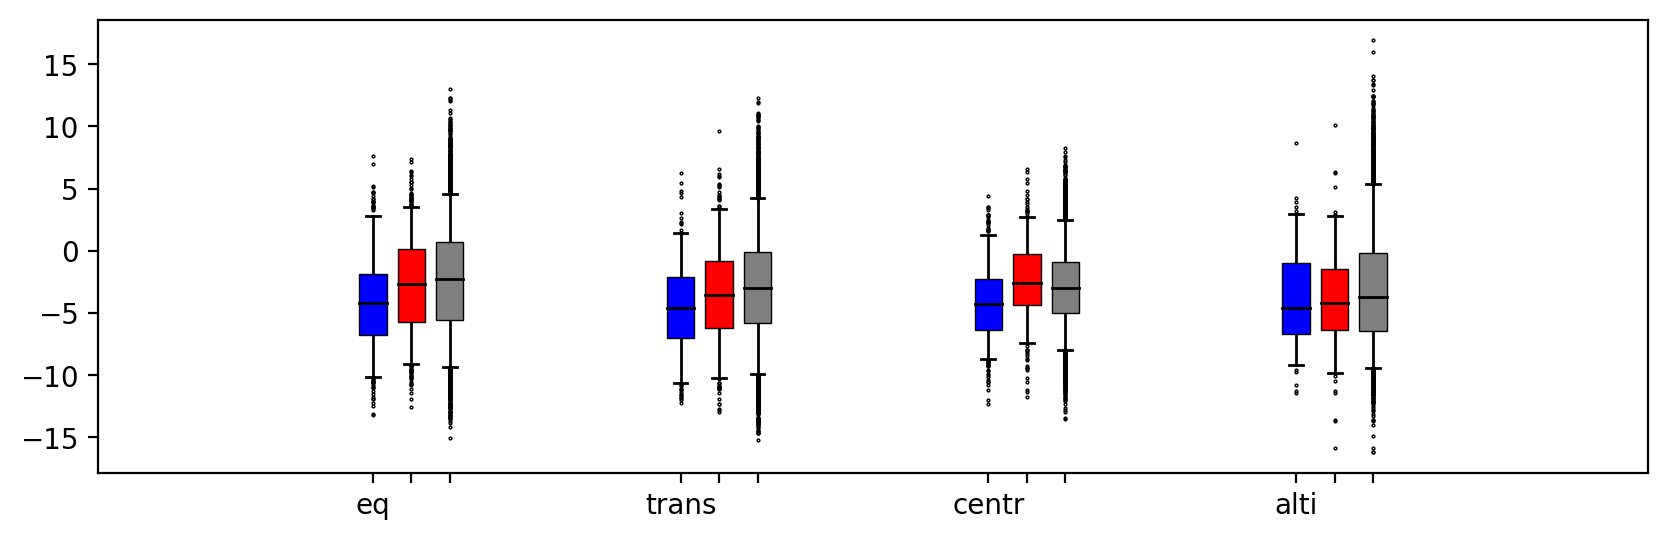

In [42]:
f = plt.figure(figsize=(10,3), dpi=200)
ids = 1
labels=['eq', 'trans', 'centr', 'alti']
bpos = np.linspace(0.45,2.13,len(labels))
ax = f.add_subplot(111)
cnt = 0
#for qw, qd in zip(wet_rscat['u8'],dry_rscat['u8']):

var = 'v8'
    
ax.boxplot(wet_rscat[var], positions=bpos, labels=labels, whis=[5,95], patch_artist=True, widths=0.05, boxprops=dict(facecolor='blue', lw=0.5), sym='.', medianprops=dict(color='k'), flierprops=dict(markersize=1))
ax.boxplot(dry_rscat[var], positions=bpos+0.07, labels=['']*len(labels), whis=[5,95], patch_artist=True, widths=0.05, boxprops=dict(facecolor='red', lw=0.5), sym='.', medianprops=dict(color='k'), flierprops=dict(markersize=1))
ax.boxplot(clim_rscat[var], positions=bpos+0.14, labels=['']*len(labels), whis=[5,95], patch_artist=True, widths=0.05, boxprops=dict(facecolor='grey', lw=0.5), sym='.', medianprops=dict(color='k'), flierprops=dict(markersize=1))

for qw, qd in zip(wet_rscat[var],dry_rscat[var]):
    print(stats.ttest_ind(qw, qd, equal_var=False))


In [1]:
def corr(a, b, bsingle=None, c_box=None):
    ds = xr.Dataset()
    ds['pval'] = a.copy(deep=True).sum('time') * np.nan
    ds['r'] = a.copy(deep=True).sum('time') * np.nan
    ds['slope'] = a.copy(deep=True).sum('time') * np.nan

    corr_box = c_box

    if bsingle:
        bb = b
    else:
        bb = b.sel(latitude=slice(corr_box[2], corr_box[3]), longitude=slice(corr_box[0], corr_box[1])).mean(dim=['latitude', 'longitude'])

    for lat in a.latitude.values:
        for lon in a.longitude.values:
            aa = a.sel(latitude=lat, longitude=lon)
            if bsingle:
                #r, p = stats.pearsonr(aa.values, bb)

                #pf = np.polyfit(aa.values, bb, 1)
                pf, intercept, r, p, std_err = stats.linregress(aa.values, bb)
            else:
                # r, p = stats.pearsonr(aa.values, bb.values)
                # pf = np.polyfit(aa.values, bb.values, 1)
                pf, intercept, r, p, std_err = stats.linregress(aa.values, bb.values)


            slope = pf#[0]

            if (np.nansum(aa.values == 0) >= 10):
                p = np.nan
                r = np.nan

            ds['r'].loc[{'latitude': lat, 'longitude': lon}] = r
            ds['pval'].loc[{'latitude': lat, 'longitude': lon}] = p
            ds['slope'].loc[{'latitude': lat, 'longitude': lon}] = slope
            #ds['intercept'].loc[{'latitude': lat, 'longitude': lon}] = intercept

    return ds